In [32]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, r2_score, mean_absolute_error

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy
from surprise import KNNBasic

In [2]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from gensim.models import FastText

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

2023-11-21 20:00:38.972424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 20:00:58.142127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
taste_profile_df = pd.read_csv('/home/016651544/DATA-270/datasets/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'], nrows = 2000000)
taste_profile_df.shape


(2000000, 3)

In [5]:
taste_profile_df.head(8)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


In [6]:
taste_profile_df.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [7]:
taste_profile_df.duplicated().sum()

0

In [8]:
song_data_df = tables.open_file("/home/016651544/DATA-270/datasets/msd_summary_file.h5", mode="r")
song_analysis_data_table = song_data_df.root.analysis.songs
metadata_table_df = pd.DataFrame.from_records(song_analysis_data_table[:])
metadata_table_df.shape

(1000000, 31)

In [9]:
metadata_table_df.dtypes

analysis_sample_rate                int32
audio_md5                          object
danceability                      float64
duration                          float64
end_of_fade_in                    float64
energy                            float64
idx_bars_confidence                 int32
idx_bars_start                      int32
idx_beats_confidence                int32
idx_beats_start                     int32
idx_sections_confidence             int32
idx_sections_start                  int32
idx_segments_confidence             int32
idx_segments_loudness_max           int32
idx_segments_loudness_max_time      int32
idx_segments_loudness_start         int32
idx_segments_pitches                int32
idx_segments_start                  int32
idx_segments_timbre                 int32
idx_tatums_confidence               int32
idx_tatums_start                    int32
key                                 int32
key_confidence                    float64
loudness                          

In [10]:
metadata_table_df.describe()

,analysis_sample_rate,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,idx_sections_confidence,...,idx_tatums_start,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,22050.0,0.0,249.500755,0.819850,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.321964,0.442496,-10.124039,0.666408,0.472109,240.625024,123.889218,3.593947,0.515916
std,0.0,0.0,126.229636,3.304457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.601595,0.276719,5.197245,0.471496,0.192613,124.079924,35.055981,1.221925,0.371903
min,22050.0,0.0,0.313020,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,-58.178000,0.000000,0.000000,0.313000,0.000000,0.000000,0.000000
25%,22050.0,0.0,180.740770,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.000000,0.212000,-12.672000,0.000000,0.356000,173.180000,97.995000,3.000000,0.125000
50%,22050.0,0.0,228.858320,0.194000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.000000,0.462000,-8.963000,1.000000,0.483000,219.759000,122.086000,4.000000,0.557000
75%,22050.0,0.0,289.932610,0.432000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.000000,0.652000,-6.386000,1.000000,0.602000,279.713000,144.089000,4.000000,0.869000
max,22050.0,0.0,3034.905670,1163.941000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.000000,1.000000,4.318000,1.000000,1.000000,3030.622000,302.300000,7.000000,1.000000


In [11]:
metadata_table_df.drop(columns =['danceability', 'energy','analysis_sample_rate', 'audio_md5','end_of_fade_in', 'idx_bars_confidence', 'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence','idx_sections_start','idx_segments_confidence', 'idx_segments_loudness_max', 'idx_segments_loudness_max_time', 'idx_segments_loudness_start', 'idx_segments_pitches', 'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence', 'idx_tatums_start', 'key_confidence', 'mode_confidence', 'start_of_fade_out', 'time_signature', 'time_signature_confidence'],inplace=True)
metadata_table_df.replace({b'': np.nan}, inplace=True)
print(metadata_table_df.isna().sum())


duration    0
key         0
loudness    0
mode        0
tempo       0
track_id    0
dtype: int64


In [12]:
metadata_table_df.head(10)

,duration,key,loudness,mode,tempo,track_id
0,252.05506,10,-4.829,0,87.002,b'TRMMMYQ128F932D901'
1,156.55138,9,-10.555,1,150.778,b'TRMMMKD128F425225D'
2,138.97098,7,-2.060,1,177.768,b'TRMMMRX128F93187D9'
3,145.05751,7,-4.654,1,87.433,b'TRMMMCH128F425532C'
4,514.29832,5,-7.806,0,140.035,b'TRMMMWA128F426B589'
5,816.53506,10,-21.420,1,90.689,b'TRMMMXN128F42936A5'
6,212.37506,3,-4.931,0,101.450,b'TRMMMLR128F1494097'
7,221.20444,11,-12.214,0,98.020,b'TRMMMBB12903CB7D21'
8,139.17995,5,-10.705,1,115.427,b'TRMMMHY12903CB53F1'
9,104.48934,4,-20.160,0,124.339,b'TRMMMML128F4280EE9'


In [13]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(8)

,duration,key,loudness,mode,tempo,track_id
0,252.05506,10,-4.829,0,87.002,TRMMMYQ128F932D901
1,156.55138,9,-10.555,1,150.778,TRMMMKD128F425225D
2,138.97098,7,-2.060,1,177.768,TRMMMRX128F93187D9
3,145.05751,7,-4.654,1,87.433,TRMMMCH128F425532C
4,514.29832,5,-7.806,0,140.035,TRMMMWA128F426B589
5,816.53506,10,-21.420,1,90.689,TRMMMXN128F42936A5
6,212.37506,3,-4.931,0,101.450,TRMMMLR128F1494097
7,221.20444,11,-12.214,0,98.020,TRMMMBB12903CB7D21


In [14]:
song_metadata_table = song_data_df.root.metadata.songs
song_metadata_table_df = pd.DataFrame.from_records(song_metadata_table[:])
song_metadata_table_df.shape

(1000000, 20)

In [15]:
song_metadata_table_df.drop(columns =['genre', 'analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
song_metadata_table_df.replace({b'': np.nan}, inplace=True)
print(song_metadata_table_df.isna().sum())

artist_familiarity       185
artist_hotttnesss         12
artist_name                0
release                    0
song_hotttnesss       418035
song_id                    0
title                     15
dtype: int64


In [16]:
song_metadata_table_df = song_metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
song_metadata_table_df.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title
0,0.649822,0.394032,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night
1,0.439604,0.356992,Karkkiautomaatti,Karkuteillä,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan
2,0.643681,0.437504,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever
3,0.448501,0.372349,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Querés
4,0.000000,0.000000,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens
5,0.361287,0.109626,David Montgomery,Berwald: Symphonies Nos. 1/2/3/4,NaN,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
6,0.692923,0.453732,Sasha / Turbulence,Strictly The Best Vol. 34,NaN,SOQVRHI12A6D4FB2D7,We Have Got Love
7,0.588156,0.401092,Kris Kross,Da Bomb,NaN,SOEYRFT12AB018936C,2 Da Beat Ch'yall


In [17]:
track_metadata = pd.read_csv('/home/016651544/DATA-270/datasets/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [18]:
track_metadata.dtypes

track_id               object
title                  object
song_id                object
release                object
artist_id              object
artist_mbid            object
artist_name            object
duration              float64
artist_familiarity    float64
artist_hotttnesss     float64
year                    int64
track_7digitalid        int64
shs_perf                int64
shs_work                int64
dtype: object

In [19]:
track_metadata.drop(columns =['duration','title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)


In [20]:
# track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
# track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

In [21]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(1000000, 2)

In [22]:
track_metadata.head(8)

,track_id,song_id
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF
5,TRMMMXN128F42936A5,SOZVAPQ12A8C13B63C
6,TRMMMLR128F1494097,SOQVRHI12A6D4FB2D7
7,TRMMMBB12903CB7D21,SOEYRFT12AB018936C


In [23]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
song_data = pd.merge(song_metadata_table_df, track_merge, on='song_id', how="right")
metadata_song_analysis_data = pd.merge(metadata_table_df, song_data, on='track_id', how="right")
metadata_song_analysis_data.shape

(2162428, 15)

In [24]:
metadata_song_analysis_data = metadata_song_analysis_data.drop(metadata_song_analysis_data[metadata_song_analysis_data.duration > 480].index)
metadata_song_analysis_data = metadata_song_analysis_data.drop(metadata_song_analysis_data[metadata_song_analysis_data.duration < 60].index)

In [25]:
metadata_song_analysis_data = metadata_song_analysis_data.dropna()
metadata_song_analysis_data.drop_duplicates(inplace=True)
metadata_song_analysis_data.shape

(1806896, 15)

In [26]:
print("Columns and the datatypes in the data: \n", metadata_song_analysis_data.dtypes)
print("\n\nSummary of column statistics: \n", metadata_song_analysis_data.describe())

Columns and the datatypes in the data: 
 duration              float64
key                     int64
loudness              float64
mode                    int64
tempo                 float64
track_id               object
artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
release                object
song_hotttnesss       float64
song_id                object
title                  object
user_id                object
play_count              int64
dtype: object


Summary of column statistics: 
            duration           key      loudness          mode         tempo  \
count  1.806896e+06  1.806896e+06  1.806896e+06  1.806896e+06  1.806896e+06   
mean   2.393422e+02  5.316810e+00 -8.004042e+00  6.685260e-01  1.247210e+02   
std    6.579911e+01  3.610497e+00  3.966729e+00  4.707431e-01  3.242891e+01   
min    6.002893e+01  0.000000e+00 -4.689200e+01  0.000000e+00  0.000000e+00   
25%    1.993138e+02  2.000000e+00 -9.783000e+00  0.000000e+00  9.9

In [27]:
def remove_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    df = df[(df[column_name] >= lower) & (df[column_name] <= upper)]
    return df

metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'play_count')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'artist_familiarity')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'artist_hotttnesss')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'song_hotttnesss')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'key')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'duration')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'loudness')
metadata_song_analysis_data = remove_outliers(metadata_song_analysis_data, 'tempo')
metadata_song_analysis_data.shape


(1382104, 15)

Data Smoothing using EMR

/tmp/ipykernel_195143/2553897965.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/016651544/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


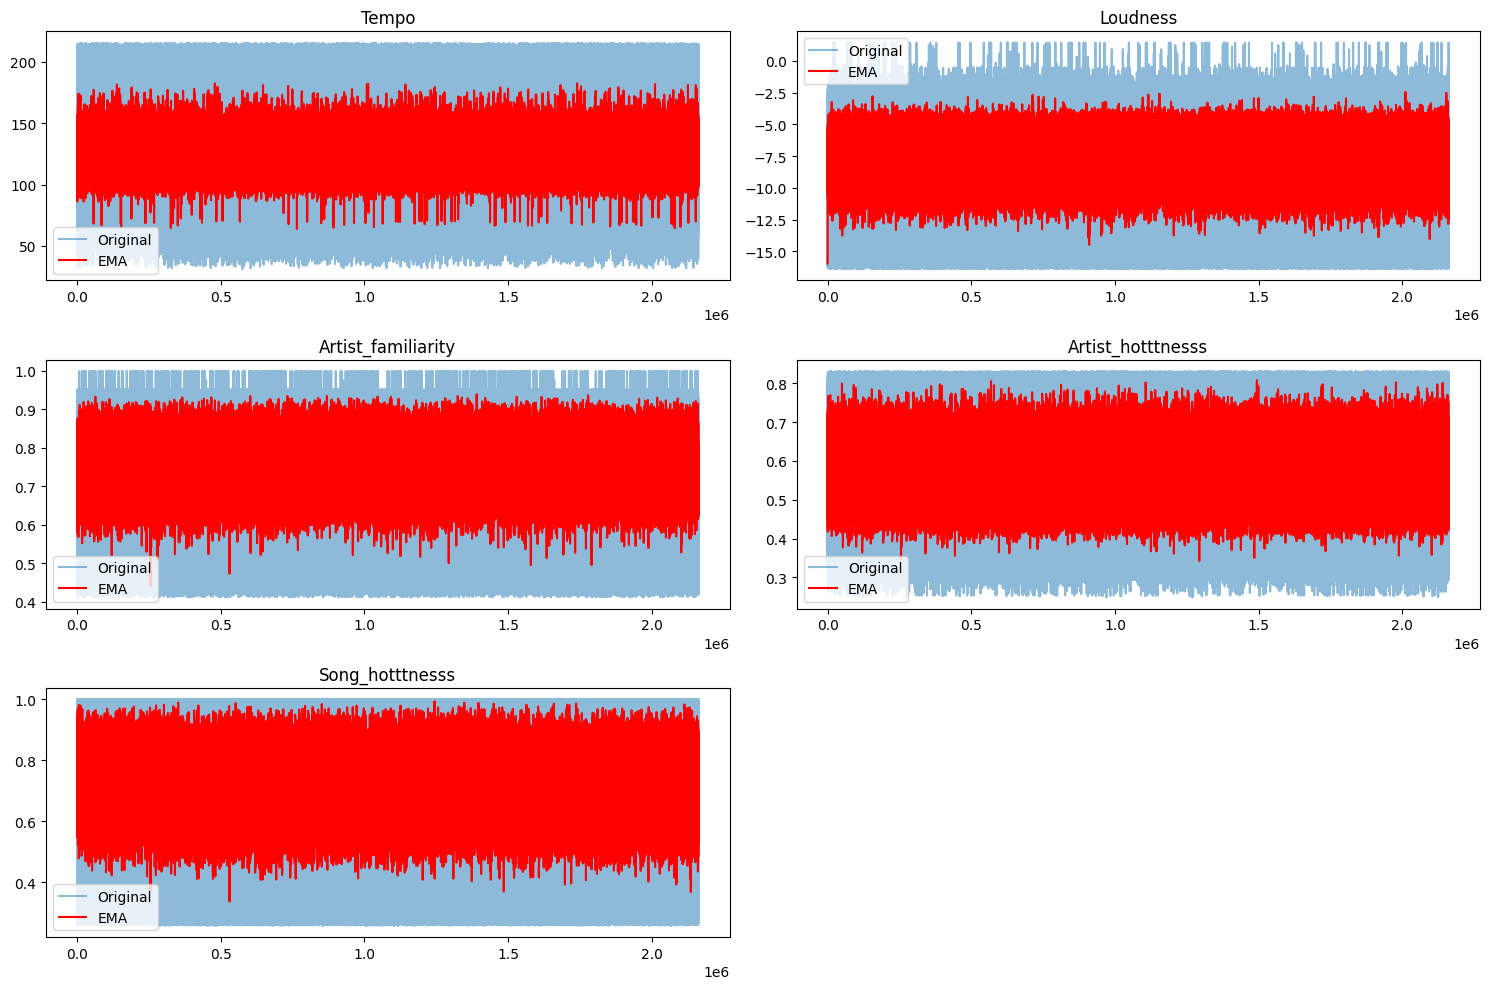

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Load your dataset here
# df = pd.read_csv('path_to_your_dataset.csv')

# Apply Exponential Moving Average smoothing
span = 10  # Adjust based on your needs
metadata_song_analysis_data['tempo_ema'] = metadata_song_analysis_data['tempo'].ewm(span=span, adjust=False).mean()
metadata_song_analysis_data['loudness_ema'] = metadata_song_analysis_data['loudness'].ewm(span=span, adjust=False).mean()
metadata_song_analysis_data['artist_familiarity_ema'] = metadata_song_analysis_data['artist_familiarity'].ewm(span=span, adjust=False).mean()
metadata_song_analysis_data['artist_hotttnesss_ema'] = metadata_song_analysis_data['artist_hotttnesss'].ewm(span=span, adjust=False).mean()
metadata_song_analysis_data['song_hotttnesss_ema'] = metadata_song_analysis_data['song_hotttnesss'].ewm(span=span, adjust=False).mean()

# Visualization
plt.figure(figsize=(15, 10))

# Creating subplots for each column
columns = ['tempo', 'loudness', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']
for i, column in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(metadata_song_analysis_data[column], label='Original', alpha=0.5)
    plt.plot(metadata_song_analysis_data[column + '_ema'], label='EMA', color='red')
    plt.title(column.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()


In [29]:
metadata_song_analysis_data = metadata_song_analysis_data.reset_index(drop=True)
#metadata_song_analysis_data.head(5)
print(metadata_song_analysis_data.head().transpose())

                                                               0  \
duration                                               112.63955   
key                                                            7   
loudness                                                 -15.948   
mode                                                           1   
tempo                                                    124.078   
track_id                                      TRIQAUQ128F42435AD   
artist_familiarity                                      0.832012   
artist_hotttnesss                                       0.677482   
artist_name                                         Jack Johnson   
release                                       Thicker Than Water   
song_hotttnesss                                         0.649006   
song_id                                       SOAKIMP12A8C130995   
title                                                   The Cove   
user_id                 b80344d063b5ccb3212f7653

In [30]:
metadata_song_analysis_data.dtypes

duration                  float64
key                         int64
loudness                  float64
mode                        int64
tempo                     float64
track_id                   object
artist_familiarity        float64
artist_hotttnesss         float64
artist_name                object
release                    object
song_hotttnesss           float64
song_id                    object
title                      object
user_id                    object
play_count                  int64
tempo_ema                 float64
loudness_ema              float64
artist_familiarity_ema    float64
artist_hotttnesss_ema     float64
song_hotttnesss_ema       float64
dtype: object

DATA REDUCTION USING PC

In [31]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have loaded your dataset into a DataFrame named 'df'
# Select the numeric features for PCA
numeric_features = metadata_song_analysis_data[['duration', 'key', 'loudness', 'mode', 'tempo', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'play_count']]

# Standardize the data
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Apply PCA
n_components = 3  # You can choose the number of components based on your requirements
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(numeric_features_scaled)

# Create a new DataFrame with the reduced dimensions
columns = [f'PC{i+1}' for i in range(n_components)]
principal_df = pd.DataFrame(data=principal_components, columns=columns)

# Concatenate the principal components with non-numeric features
final_df = pd.concat([principal_df, metadata_song_analysis_data[['track_id', 'artist_name', 'release', 'song_id', 'title', 'user_id']]], axis=1)

# Display the reduced dataset
print(final_df.head())


        PC1       PC2       PC3            track_id    artist_name  \
0 -0.064449 -1.145037 -0.196500  TRIQAUQ128F42435AD   Jack Johnson   
1  1.296489 -2.052566 -0.094753  TRIRLYL128F42539D1  Billy Preston   
2  1.157856  1.728843 -0.005572  TRMHBXZ128F4238406  Paco De Lucia   
3  0.978845 -1.573684 -1.611170  TRAHZNE128F9341B86   The Dead 60s   
4  2.365629  0.525032 -0.964794  TRJPXGD128F92F17D7          Amset   

                                             release             song_id  \
0                                 Thicker Than Water  SOAKIMP12A8C130995   
1                                         To Die For  SOAPDEY12A81C210A9   
2                                Flamenco Para Niños  SOBBMDR12A8C13253B   
3  Nick & Norah's Infinite Playlist - Original Mo...  SOBFOVM12A58A7D494   
4                                              Amset  SOBNZDC12A6D4FC103   

                             title                                   user_id  
0                         The Cove  b80344d

In [34]:
final_df.shape

(1382104, 9)